# **Maintenance Dredging**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.float_format = '{:,}'.format# show , for thousands
pd.set_option('display.max_columns', 1000)# show all columns

from pathlib import Path

# change the width of the cells on screen 
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

,Hs [m]
time,
2012-01-01 00:00:00,1.492622729
2012-01-01 01:00:00,1.564041114
2012-01-01 02:00:00,1.609562006
2012-01-01 03:00:00,1.636151964
2012-01-01 04:00:00,1.638944871


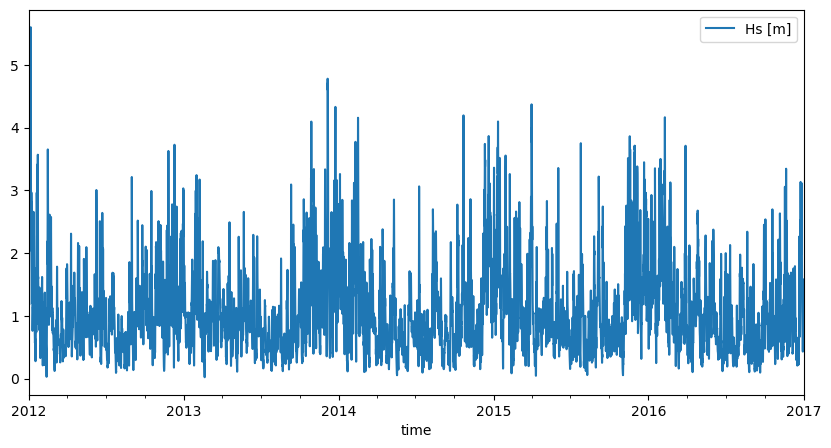

In [2]:
path = Path.cwd()
eurpfm = pd.read_csv(Path.joinpath(path, "Waves_Safe_Haven.csv"), delimiter = ',')
eurpfm['time'] = pd.to_datetime(eurpfm['time'])
eurpfm.set_index(['time'], inplace = True)

display(eurpfm.head(5))
eurpfm.plot(figsize=(10,5),subplots=True);

In [3]:
mean_overal = eurpfm.mean()
print('Mean')
print(mean_overal, "\n", )

print('Standard deviation')
std_overal = eurpfm.std()
print(std_overal)

Mean
Hs [m]   1.061542415649114
dtype: float64 

Standard deviation
Hs [m]   0.6874802644209435
dtype: float64


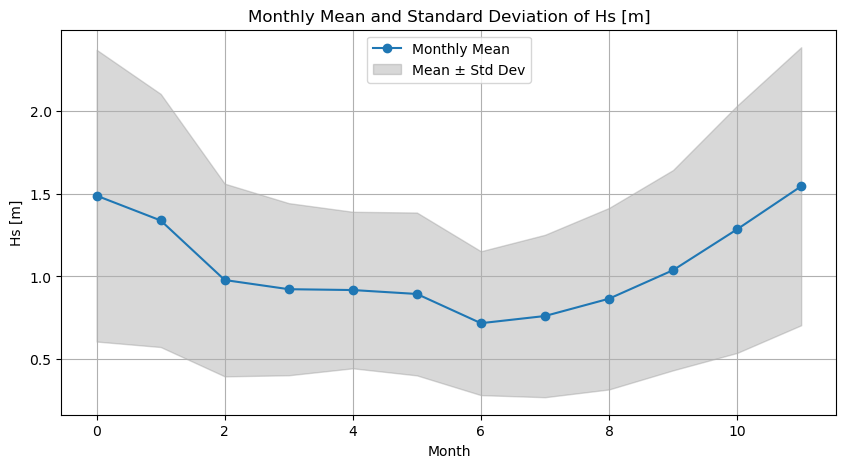

In [4]:
# Group by month (1-12) and calculate mean and std dev for each calendar month across all years
# (monthly_mean and monthly_std already exist)
monthly_mean = eurpfm.groupby(eurpfm.index.month).mean()
monthly_std = eurpfm.groupby(eurpfm.index.month).std()

plt.figure(figsize=(10,5))
plt.plot(monthly_mean.index-1, monthly_mean['Hs [m]'], marker='o', label='Monthly Mean')
plt.fill_between(monthly_mean.index-1,
                 monthly_mean['Hs [m]'] - monthly_std['Hs [m]'],
                 monthly_mean['Hs [m]'] + monthly_std['Hs [m]'],
                 color='gray', alpha=0.3, label='Mean ± Std Dev')
#plt.xticks(ticks=range(12), labels=months)
plt.xlabel('Month')
plt.ylabel('Hs [m]')
plt.title('Monthly Mean and Standard Deviation of Hs [m]')
plt.legend()
plt.grid(True)
plt.show()


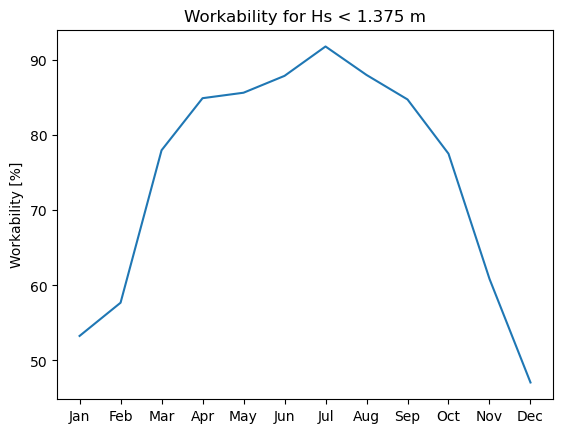

In [71]:

draught= 5.5  #CHANGE WITH BOATS
Hs_thres = 0.25 *draught  #CHANGE WITH BOAT DRAUGHT
work_ability = []

for month in range(1,12+1,1):
    data_month = eurpfm[eurpfm.index.month == month].copy()
    n_all = len(data_month)
    
    data_month = data_month[data_month['Hs [m]'] <= Hs_thres]
    n_workable = len(data_month)
    
    work_ability.append(n_workable/n_all*100)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(work_ability);
plt.xticks(np.linspace(0,11,12), months);
plt.title('Workability for Hs < '+str(Hs_thres)+' m');
plt.ylabel('Workability [%]');

# Persistency

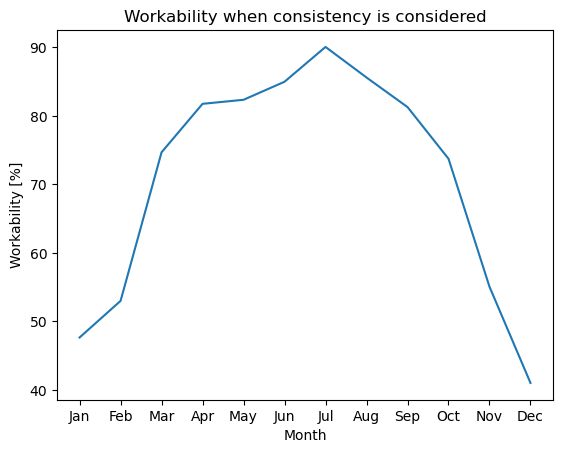

In [72]:
month_assessed = np.zeros(12)# an array that counts how many times each month is reviewed.
month_succes = np.zeros(12)# an array that will count the number of time 6 consequetive hours are occuring


for i in range(len(eurpfm)):
    period = eurpfm.iloc[i:i+6]
    
    month = period.index[0].month
    month_assessed[month-1] += 1# to zero-based

    Hs_serie = period['Hs [m]'].values.tolist()
 
    if np.max(Hs_serie) <= Hs_thres:    
        month_succes[month-1] += 1  # to zero-based
        #print(i, 'succes, Hs', np.max(Hs_serie))
    #else:
    #    print(i, 'not succes, Hs', np.max(Hs_serie), 'Wl min', np.min(WL_serie))

workability = month_succes/month_assessed*100

plt.plot(workability)
plt.title('Workability when consistency is considered')
plt.xticks(np.linspace(0,11,12), months);
plt.xlabel('Month')
plt.ylabel('Workability [%]');


**Using THSD Easydredge 1700 - calculate the production and how much time to dredge 5 m deep sand sediment**

In [83]:
Hopper_capacity = 2700 # m3
suction_diameter = 700 #mm
Power = 940 #kW dredge pump diesel engine
v_TSHD = 11.5 #knots 
v = 3 #m/s
fraction_sand = 0.35

prod = -6500*suction_diameter/1000 + 1250*(suction_diameter/1000)*np.log(Power)

print('Maximum hourly dry mass production:', round(prod), 'm3/h')
print('Maximum production per week:', round(prod*24*7), 'm3/week')

Maximum hourly dry mass production: 1440 m3/h
Maximum production per week: 241944 m3/week


In [84]:
rho_mix = 1400
rho_sea = 1025
rho_sand = 2000

sand_fraction = 0.35
settlement_factor = 0.25
trapping_factor = 0.05
overflow_duration = 45 # mins
max_density = 2200
found = False

for overflow_duration_test in range(0, 46):  # 0 to 45 minutes
    solid_percentage = (rho_mix - rho_sea) / (rho_sand - rho_sea)
    mass_dry = prod * rho_sand
    mass_mix = mass_dry / solid_percentage
    volume_mix = mass_mix / rho_mix
    Load_time = Hopper_capacity / volume_mix  # hours

    mass_fines_mix = mass_mix * sand_fraction
    mass_fines_stirred = mass_fines_mix * 0.03
    mass_fines_settle = mass_fines_mix - mass_fines_stirred
    mass_overflow = ((Load_time * 60 + overflow_duration_test) / (Load_time * 60)) * (1 - settlement_factor) * (1 - trapping_factor) * mass_fines_settle
    rho_overflow = ((mass_mix - mass_overflow) / mass_mix) * rho_sea + (mass_overflow / mass_mix) * rho_sand

    # stop if density reaches or exceeds max_density (including at 45 min)
    if rho_overflow >= max_density:
        print(f"Maximum allowed overflow duration: {overflow_duration_test} min")
        print(f"Density of overflow water: {rho_overflow:.1f} kg/m³")
        found = True
        break

if not found:
    # did not reach max density within 0-45 min -> force use of 45 min
    overflow_duration_test = 45
    print("Overflow density did not reach 2200 kg/m³ within 45 minutes. Using 45 min as overflow duration.")
    print(f"Density of overflow water at 45 min: {rho_overflow:.1f} kg/m³")

t_loading = Load_time*60 + (overflow_duration_test-1) # total cycle time (min)
print(f"Total time loading: {t_loading:.1f} mins")

# 🔹 Sand volume and mass per cycle
solid_fraction = (rho_mix - rho_sea) / (rho_sand - rho_sea)
sand_volume_cycle = Hopper_capacity * solid_fraction
sand_mass_cycle = sand_volume_cycle * rho_sand

print(f"Sand volume per cycle: {sand_volume_cycle:.1f} m³")
print(f"Sand mass per cycle: {sand_mass_cycle/1000:.1f} tonnes")


Overflow density did not reach 2200 kg/m³ within 45 minutes. Using 45 min as overflow duration.
Density of overflow water at 45 min: 1611.3 kg/m³
Total time loading: 74.3 mins
Sand volume per cycle: 1038.5 m³
Sand mass per cycle: 2076.9 tonnes


In [85]:
beach_distance = 3 #km
v_TSHD = 11.5*0.514*60 #convert to m/minute
t_sailing = beach_distance*1000/v_TSHD #in minutes
t_discharge = 10
t_maneuvering = 15
t_cycle = t_loading + t_sailing + t_discharge + t_sailing*0.9 +t_maneuvering
print(f"Total cycle time: {t_cycle:.1f} mins")
print(f"Sailing time: {t_sailing:.1f} mins")
print(f"Discharge time: {t_discharge:.1f} mins")
print(f"Maneuvering time: {t_maneuvering:.1f} mins")


Total cycle time: 115.4 mins
Sailing time: 8.5 mins
Discharge time: 10.0 mins
Maneuvering time: 15.0 mins


In [90]:
rho_sand = 2000        # sediment density (kg/m³)
length = 1000          # channel length (m)
depth_start = 13       # initial depth (m)
depth_threshold = 8    # threshold depth for reference
B_top_sand = 220       # top width at 8 m depth (m)
width_at_8m = B_top_sand
slant_angle = 30       # side slope (degrees)
tan_phi = np.tan(np.radians(slant_angle))

weeks = 520
maintenance_start_week = 260   # week to start dredging
maintenance_duration = 22    # weeks to restore depth
depth = depth_start

depth_history = []
time_weeks = np.arange(weeks)
in_maintenance = False
maintenance_timer = 0

for t in range(weeks):
    if in_maintenance:
        # Maintenance dredging phase — linearly restore depth
        dredge_rate = (depth_start - depth) / (maintenance_duration - maintenance_timer)
        depth += dredge_rate
        maintenance_timer += 1

        # End maintenance
        if maintenance_timer >= maintenance_duration:
            in_maintenance = False
            maintenance_timer = 0
            depth = depth_start

    else:
        # Normal sedimentation phase
        effective_width = max(width_at_8m - max(depth - 8, 0) * tan_phi, 1.0)
        S = (250 + 260 * depth ** 1.4) * length / rho_sand  # m³/week
        d_change = S / (effective_width * length)
        depth -= d_change

        # Start maintenance at specified week
        if t + 1 == maintenance_start_week:
            in_maintenance = True
            maintenance_timer = 0
            print(f"Maintenance started at week {t+1}, depth = {depth:.2f} m")

    depth_history.append(depth)


Maintenance started at week 260, depth = 8.61 m


In [91]:

def V_trench(B,H,phi,L):#phi in degrees, B = bottom width, H = layer thickness
    phi_rad = phi*np.pi/180
    A = H*(B+H/np.tan(phi_rad))*L
    B1 = B + 2*H/np.tan(phi_rad)
    return A,B1
      
V_sand, B_top_sand = V_trench(B = 220,H = 13-8.61,phi = 30, L=1000) 
print('Sand:', round(V_sand,0) ,'m3, top width:', round(B_top_sand,0), 'm')

Sand: 999180.0 m3, top width: 235.0 m


In [95]:
n_cycles = V_sand/sand_volume_cycle
total_cycle_minutes = n_cycles * t_cycle
total_working_hours = total_cycle_minutes / 60
total_days = total_working_hours / 20
total_weeks = total_days / 7
print(f'Total days required: {total_days:.1f} days')
print(f'Total weeks required: {total_weeks:.1f} weeks')

# only use the top N highest workability months to compute average
top_n = 4
top_n = min(top_n, len(workability))
top_values = np.sort(workability)[-top_n:]
avg_workability_pct = np.mean(top_values)  # percent using only top_n months

calendar_weeks_required = total_weeks / (avg_workability_pct / 100)

print(f'number of cycles: {n_cycles:.1f}')
print(f'Average workability: {avg_workability_pct:.1f}%')
print(f'Total working weeks (calendar) considering workability: {calendar_weeks_required:.0f} weeks')

Total days required: 92.5 days
Total weeks required: 13.2 weeks
number of cycles: 962.2
Average workability: 85.7%
Total working weeks (calendar) considering workability: 15 weeks


Cycle time

In [93]:
def tshd_hourly_production(hopper_capacity_m3, load_factor, overflow_loss, cycle_time_hr, in_situ_density_t_m3):

    volume_production = hopper_capacity_m3 * load_factor * (1 - overflow_loss) / cycle_time_hr

    # Hourly production in tonnes
    mass_production = volume_production * in_situ_density_t_m3

    return volume_production, mass_production

load_factor = 0.95            
overflow_loss = 0.10      
cycle_time = 2.0 
in_situ_density = 2.0  

# Run the calculation
Qv, Qt = tshd_hourly_production(Hopper_capacity, load_factor, overflow_loss, cycle_time, in_situ_density)

print(f"Hourly production (volume): {Qv:,.0f} m³/hr")
print(f"Hourly production (mass):   {Qt:,.0f} tonnes/hr")


Hourly production (volume): 1,154 m³/hr
Hourly production (mass):   2,308 tonnes/hr


**Sedimentation rate & dredging cycle**

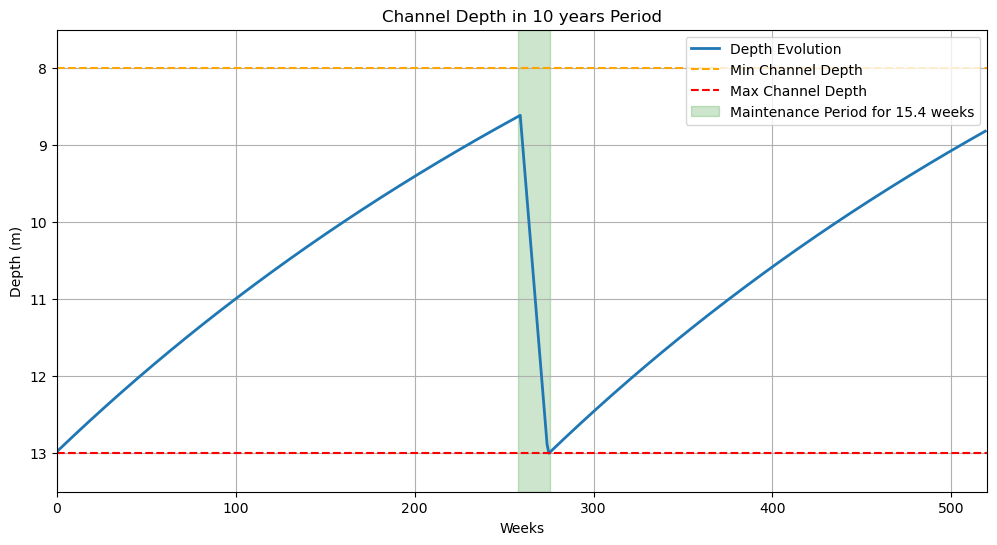

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
rho_sand = 2000        # sediment density (kg/m³)
length = 1000          # channel length (m)
depth_start = 13       # initial depth (m)
depth_threshold = 8    # threshold depth for reference
B_top_sand = 220       # top width at 8 m depth (m)
width_at_8m = B_top_sand
slant_angle = 30       # side slope (degrees)
tan_phi = np.tan(np.radians(slant_angle))

weeks = 520
maintenance_start_week = 260   # week to start dredging
maintenance_duration = calendar_weeks_required    # weeks to restore depth
depth = depth_start

depth_history = []
time_weeks = np.arange(weeks)
in_maintenance = False
maintenance_timer = 0

for t in range(weeks):
    if in_maintenance:
        # Maintenance dredging phase — linearly restore depth
        dredge_rate = (depth_start - depth) / (maintenance_duration - maintenance_timer)
        depth += dredge_rate
        maintenance_timer += 1

        # End maintenance
        if maintenance_timer >= maintenance_duration:
            in_maintenance = False
            maintenance_timer = 0
            depth = depth_start

    else:
        # Normal sedimentation phase
        effective_width = max(width_at_8m - max(depth - 8, 0) * tan_phi, 1.0)
        S = (250 + 260 * depth ** 1.4) * length / rho_sand  # m³/week
        d_change = S / (effective_width * length)
        depth -= d_change

        # Start maintenance at specified week
        if t + 1 == maintenance_start_week:
            in_maintenance = True
            maintenance_timer = 0

    depth_history.append(depth)

# --- Plot results ---
plt.figure(figsize=(12, 6))
plt.plot(time_weeks, depth_history, linewidth=2, label='Depth Evolution')

# Reference lines
plt.axhline(depth_threshold, linestyle='--', color='orange', label='Min Channel Depth')
plt.axhline(depth_start, linestyle='--', color='red', label='Max Channel Depth')

# Maintenance shaded box
plt.axvspan(maintenance_start_week-2, maintenance_start_week + maintenance_duration, 
            color='green', alpha=0.2, label=f'Maintenance Period for {calendar_weeks_required:.1f} weeks')

plt.gca().invert_yaxis()
plt.title("Channel Depth in 10 years Period")
plt.xlabel("Weeks")
plt.ylabel("Depth (m)")
plt.ylim(13.5,7.5)
plt.xlim(0, weeks)
plt.legend()
plt.grid(True)
plt.show()
